# Import lib 
Tìm contours -> Match contours với từ điển kí tụ -> Regconize chữ

In [84]:
from google.colab.patches import cv2_imshow
import cv2 
import numpy as np
import pandas as pd
import argparse
import random as rng
import matplotlib.pyplot as plt

rng.seed(42)

# Resize image

In [85]:
def resize(image: np.array) -> np.array:
    image = cv2.resize(image, (int(image.shape[1]/(image.shape[0]/100)),100), 3)
    return image

# Tìm tất cả contours trong ảnh

In [141]:
def binarize(image, thr: int = 200):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray < 200] = 0
    gray[gray >= 200] = 255
    return gray

In [93]:
from typing import Tuple, List, Dict
def getContoursAndAreas(gray: np.array) -> Tuple[List, List]:

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    bboxes = [(i, cv2.boundingRect(cnt)) for i, cnt in enumerate(contours)]
    bboxes = sorted(bboxes, key=lambda x: x[1][0])
    contours = [contours[i] for i, _ in bboxes]

    cv2_imshow(gray)
    cv2.waitKey(0)
      
    print("Number of Contours found = " + str(len(contours)))

    area = []
    for i in contours:
        area.append(cv2.contourArea(i))
    print(area)
    return contours, area

# Vẽ contours lên ảnh gốc

In [100]:
def drawContours(image: np.array, contours: list, backgroundColor: int = 150, path_save: str = 'temp.png'):
    # Draw all contours
    # -1 signifies drawing all contours
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
      
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(path_save,image)

# So sánh chữ tương đồng

In [88]:
def matchWord(contours1: list, contours2: list):
    cnt1 = contours1
    cnt2 = contours2

    ret12 = cv2.matchShapes(cnt1,cnt2,1,0.0)
    return ret12

In [169]:
def matchShapes(cnt1, cnt2, img1=None, img2=None, show=False):
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)
    if img1 is not None:
        img1 = cv2.ximgproc.thinning(img1)
        img2 = cv2.ximgproc.thinning(img2)
        img1 = img1[y1:y1+h1, x1:x1+w1]
        img2 = img2[y2:y2+h2, x2:x2+w2]
        w, h = max(w1, w2), max(h1, h2)
        img1 = cv2.resize(img1, (w, h), interpolation=cv2.INTER_NEAREST)
        img2 = cv2.resize(img2, (w, h), interpolation=cv2.INTER_NEAREST)
        
        img1 = cv2.dilate(img1, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=3)
        img2 = cv2.dilate(img2, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=3)
        # ret = cv2.matchShapes(img1, img2, 1, 0.0)
        sub = img1.astype('int32') - img2.astype('int32')
        ret = np.count_nonzero(sub)/np.count_nonzero(sub == 0)
        if show:
            cv2_imshow(np.abs(sub).astype('uint8'))
        
        
    else:
        cnt1 = cnt1 - np.tile(np.array([x1, y1]), cnt1.shape[0]).reshape(-1, 1, 2)
        cnt2 = cnt2 - np.tile(np.array([x2, y2]), cnt2.shape[0]).reshape(-1, 1, 2)
        cnt2 = (cnt2 * np.tile(np.array([w1/w2, h1/h2]), cnt2.shape[0]).reshape(-1, 1, 2)).astype(np.int32)
        ret = cv2.matchShapes(cnt1, cnt2, 1, 0.0)
        img1 = np.zeros((h1, w1), dtype='uint8')
        img2 = np.zeros((h1, w1), dtype='uint8')
        loc1 = cnt1.reshape(-1, 2).transpose()
        loc1 = (loc1[1], loc1[0])
        loc2 = cnt2.reshape(-1, 2).transpose()
        loc2 = (loc2[1], loc2[0])
        img1[loc1] = 255
        img2[loc2] = 255
    
    if show:
        cv2_imshow(img1)
        cv2_imshow(img2)

    return ret

# Xây dựng từ điển chữ cái

In [130]:
dictionary = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]
len(dictionary)
def buildDict(contours: list, _dictionary: list = dictionary) -> Dict[str, np.array]:
    d = dict()
    for i in range(len(contours)):
        d[_dictionary[i]] = contours[i]
    return d

# Hàm nhận diện chữ cái

In [90]:
# letters_dict = ??? # create a dictionary to match, format: key: string char; value: list of ndarray (the array of reading image) (ALMOST DONE)

def getRecognization(contours: list, letters_dict: dict, threshhold: int) -> str:
    store = ''
    for contour in contours:
        maxMatch = 0
        pos = 0
        for key, val in letters_dict.items():
            # for toMatch in val:
            g = cv2.matchShapes(contour,val,1,0.0)
            if (g > maxMatch):
                maxMatch = g
                pos = key
        if maxMatch < threshhold:
            continue
        store += pos
    return store

# Main

[i] Read image done !


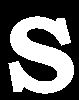

Number of Contours found = 1
[2923.5]


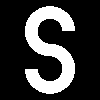

Number of Contours found = 1
[2073.0]


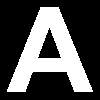

Number of Contours found = 1
[3484.5]


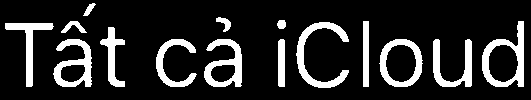

Number of Contours found = 15
[628.0, 1106.0, 109.0, 57.0, 492.0, 572.0, 1110.5, 86.5, 54.5, 279.0, 853.0, 325.0, 1631.0, 665.0, 1784.5]


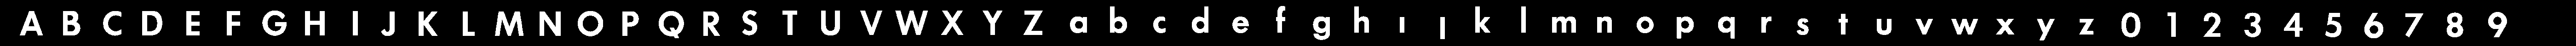

Number of Contours found = 62
[1288.0, 1683.5, 879.0, 2019.5, 954.0, 809.5, 1334.5, 1218.0, 520.0, 653.0, 1148.5, 640.5, 1683.0, 1432.5, 2333.0, 1207.0, 2356.0, 1353.5, 894.5, 689.0, 1124.0, 907.0, 1686.0, 1061.5, 762.0, 1012.5, 1117.0, 1317.0, 514.5, 1269.0, 838.5, 645.0, 1409.5, 907.5, 297.0, 423.0, 878.0, 504.0, 1087.5, 699.5, 999.0, 1212.0, 1171.5, 410.5, 532.5, 468.0, 671.0, 558.0, 997.0, 681.0, 685.0, 600.5, 1749.0, 524.5, 918.0, 876.5, 1004.0, 854.0, 1404.5, 689.5, 1506.0, 1372.0]
[i] Get Contours done !


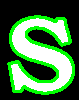

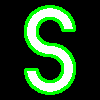

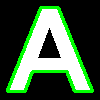

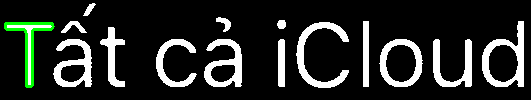

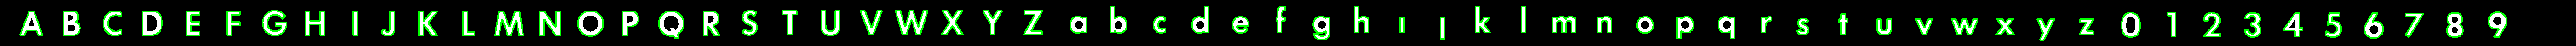

[i] Draw contours done !
[i] Build dictionary done !
TdA8lOd2TIOlOUd
TEST MATCH SHAPE CONTOURS


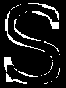

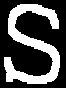

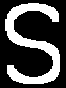

S match S:  0.12296983758700696


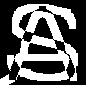

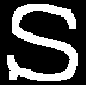

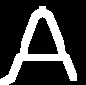

S match A:  0.6154696132596685


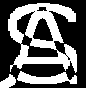

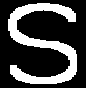

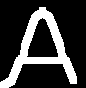

The remain S match A:  0.6271769511932918


In [170]:
### TEST ###
def main():
    img1 = 255 - binarize(resize(cv2.imread('img1.png')))
    cv2.waitKey(0)
    img2 = 255 - binarize(resize(cv2.imread('img2.png')))
    cv2.waitKey(0)
    img3 = 255 - binarize(resize(cv2.imread('img3.png')))
    cv2.waitKey(0)
    img4 = 255 - binarize(resize(cv2.imread('img4.png')))
    cv2.waitKey(0)
    img5 = 255 - binarize(resize(cv2.imread('img5.png')))
    cv2.waitKey(0)
    print('[i] Read image done !')

    img_contours1, area1 = getContoursAndAreas(img1)
    img_contours2, area2 = getContoursAndAreas(img2)
    img_contours3, area3 = getContoursAndAreas(img3)
    img_contours4, area4 = getContoursAndAreas(img4)
    img_contours5, area5 = getContoursAndAreas(img5)
    print('[i] Get Contours done !')

    drawContours(img1, img_contours1, 'img1.png')
    drawContours(img2, img_contours2, 'img2.png')
    drawContours(img3, img_contours3, 'img3.png')
    drawContours(img4, img_contours4[0], 'img4.png')
    drawContours(img5, img_contours5, 'img5.png')
    print('[i] Draw contours done !')

    # Build dictionary
    dic = buildDict(img_contours5, dictionary)
    print('[i] Build dictionary done !')
    for cnt in img_contours4:
        a = []
        for key, val in dic.items():
            a.append((key,matchShapes(cnt,val, img4, img5)))
        print(sorted(a, key = lambda x : x[1])[0][0], end='')
    print()
    
    print("TEST MATCH SHAPE CONTOURS")
    print("S match S: ", matchShapes(img_contours1[0], img_contours2[0], img1, img2, show=True))
    print("S match A: ", matchShapes(img_contours1[0], img_contours3[0], img1, img3, show=True))
    print("The remain S match A: ", matchShapes(img_contours2[0], img_contours3[0], img2, img3, show=True))

    # print("TEST MATCH SHAPE IMAGES")
    
    # print("S match S: ", cv2.matchShapes(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY),1,0.0))
    # print("S match A: ", cv2.matchShapes(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY),1,0.0))
    # print("The remain S match A: ", cv2.matchShapes(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY),1,0.0))
    # print("The remain S match A: ", cv2.matchShapes(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY),1,0.0))
    

    # print(getRecognization())
    # Test img data1.png

    # # plot the histogram
    # plt.figure()
    # plt.title("Contours Area Histogram")
    # plt.xlabel("Bins")
    # plt.ylabel("# of Pixels")
    # plt.plot(hist)
    # plt.xlim([0, 256])

    # print("Error match fit: ", str(matchWord(img_contours1, img_contours2)))
    # print("Error match fake 1: ", str(matchWord(img_contours1, img_contours3)))
    # print("Error match fake 2: ", str(matchWord(img_contours1, img_contours2)))
    # print("Error match itself: ", str(matchWord(img_contours1, img_contours2)))
main()

In [ ]:
print(dic)

In [ ]:
img4 = cv.imread("data1.png", 0)
ret, thresh4 = cv.threshold(img4,220,256, cv.THRESH_BINARY)

contours4,hiearachy4 = cv.findContours(thresh4,2,1)
cnt4 = contours4[0]


In [ ]:
for i in contours4:
  # temp = np.ndarray(i)
  # cv2_imshow(temp)
  img_contours = np.zeros(img.shape)
  cv.drawContours(img_contours, contours4, -1, (0,255,0), 3)
  print(i.shape)



(49, 1, 2)
(50, 1, 2)
(78, 1, 2)
(80, 1, 2)
(1094, 1, 2)
(209, 1, 2)
(96, 1, 2)
(124, 1, 2)
(178, 1, 2)
(181, 1, 2)
(182, 1, 2)
(152, 1, 2)
(194, 1, 2)
(243, 1, 2)
(182, 1, 2)
(130, 1, 2)
(58, 1, 2)
(29, 1, 2)
(47, 1, 2)
(36, 1, 2)


In [ ]:
img_contours = np.full(img3.shape, 100)
cv.drawContours(img_contours, contours3, -1, (0,255,0), 3)
cv.imwrite('contours.png',img_contours) 
print("Number of Contours found = " + str(len(contours3)))

Number of Contours found = 10


In [ ]:
0contours4

[array([[[192,  57]],
 
        [[191,  58]],
 
        [[190,  58]],
 
        [[189,  58]],
 
        [[188,  59]],
 
        [[187,  59]],
 
        [[186,  59]],
 
        [[185,  60]],
 
        [[185,  61]],
 
        [[184,  62]],
 
        [[184,  63]],
 
        [[184,  64]],
 
        [[184,  65]],
 
        [[185,  66]],
 
        [[185,  67]],
 
        [[186,  68]],
 
        [[187,  68]],
 
        [[188,  69]],
 
        [[189,  69]],
 
        [[190,  69]],
 
        [[191,  69]],
 
        [[192,  70]],
 
        [[193,  69]],
 
        [[194,  69]],
 
        [[195,  69]],
 
        [[196,  69]],
 
        [[197,  68]],
 
        [[198,  68]],
 
        [[199,  68]],
 
        [[199,  67]],
 
        [[200,  66]],
 
        [[201,  65]],
 
        [[202,  64]],
 
        [[202,  63]],
 
        [[202,  62]],
 
        [[203,  61]],
 
        [[203,  60]],
 
        [[203,  59]],
 
        [[203,  58]],
 
        [[202,  57]],
 
        [[201,  57]],
 
        [[200,  

In [ ]:
import cv2
import numpy as np

img = cv2.imread('/content/data1.png', cv2.IMREAD_UNCHANGED)

#convert img to grey
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
#find contours
contours, hierarchy = cv2.findContours(thresh_img, 2,1)

#create an empty image for contours
img_contours = np.zeros(img.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,150,120), 3)
#save image
cv2.imwrite('abc.png',img_contours) 

True

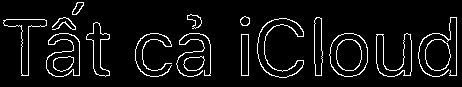

Number of Contours found = 17


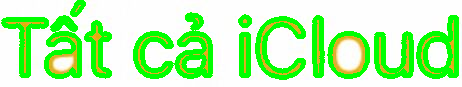

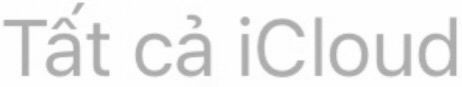

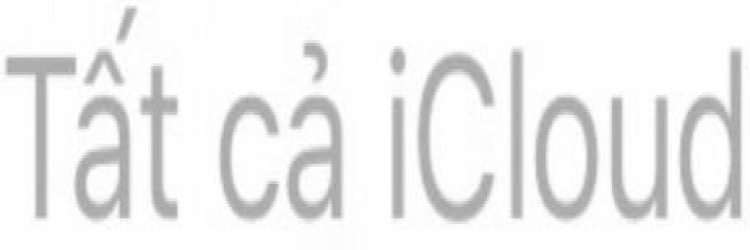

In [ ]:
a = cv2.imread("data1.png", 0)
b = cv2.resize(a, (750,250), interpolation = cv2.INTER_AREA)
cv2_imshow(a)
cv2_imshow(b)